In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import MeanSquareErrorLoss, LogCoshLoss
from mygrad.optimizers import SGD
from mygrad.preprocessors import MinMaxScaler, StandardScaler, IdentityScaler
from mygrad.trainers import RegressionTrainer
from mygrad.dataloaders import NumpyRegressionDataloader

/tmp/ipykernel_133356/3420663721.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Steps Small

In [2]:
train_df = pd.read_csv("../mio1/regression/steps-small-training.csv")
test_df = pd.read_csv("../mio1/regression/steps-small-test.csv")

In [3]:
X_train = train_df["x"].values
y_train = train_df["y"].values

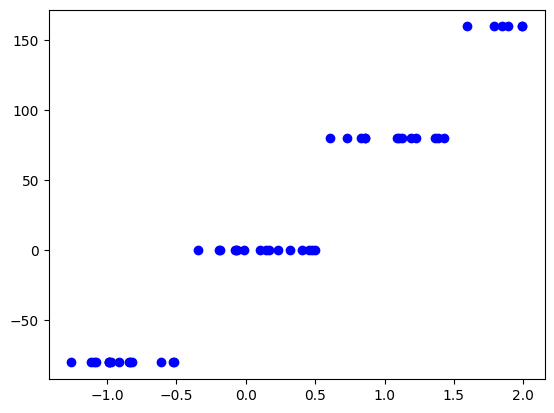

In [4]:
p = np.argsort(X_train)
plt.plot(X_train[p], y_train[p], "bo")

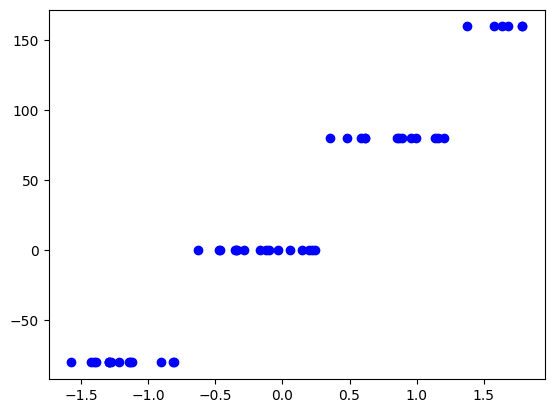

In [5]:
input_normalizer = StandardScaler()
output_normalizer = IdentityScaler()

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

X_train_scaled = input_normalizer.fit_transform(X_train)
y_train_scaled = output_normalizer.fit_transform(y_train)

plt.plot(X_train_scaled[p, :], y_train_scaled[p, :], "bo")

In [6]:
len(X_train_scaled)

50

In [9]:
model = mc.Sequential(
    mc.Linear(1, 10, init="he"),
    mc.Tanh(),
    mc.Linear(10, 10, init="he"),
    mc.Tanh(),
    mc.Linear(10, 1, init="uniform"),
)
optimizer = SGD(model.parameters(), learning_rate=6e-4, momentum=0.8, dampening=0.8, nesterov=True)
loss = MeanSquareErrorLoss()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=10, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader)
train_losses, _ = trainer.train(3_000)

print(train_losses[-20:].max())


Training epochs:   0%|          | 0/3000 [00:00<?, ?it/s]

0.17629806990408614


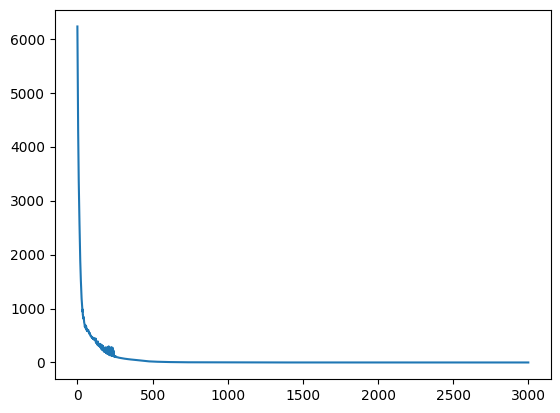

In [10]:
plt.plot(train_losses)
plt.show()

In [11]:
optimizer = SGD(model.parameters(), learning_rate=3e-3)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=50, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, store_params_angle_diffs=True, store_params_lengths=True)
train_losses, _ = trainer.train(100_000)

print(train_losses[-20:].max())

Training epochs:   0%|          | 0/100000 [00:00<?, ?it/s]

0.0030165240419117497


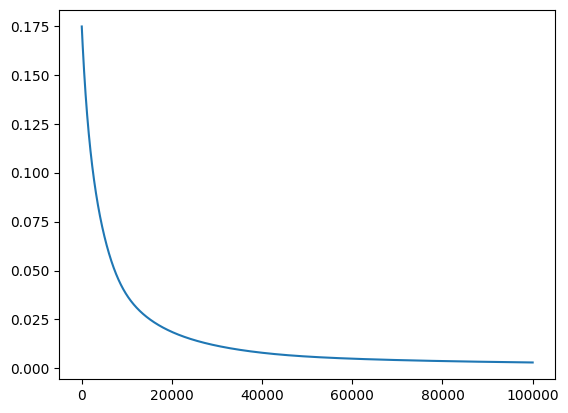

In [12]:
plt.plot(train_losses)
plt.show()

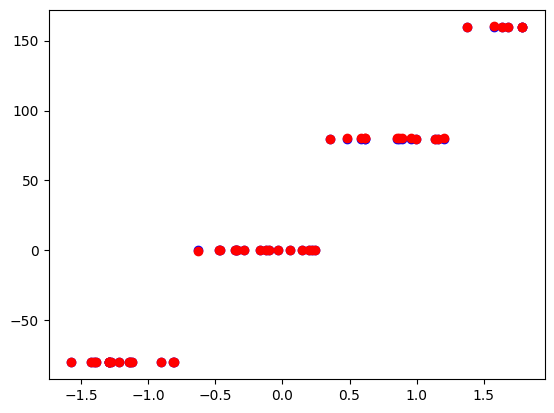

In [13]:
y_pred = model.forward(X_train_scaled)
plt.plot(X_train_scaled, y_train_scaled, "bo")
plt.plot(X_train_scaled, y_pred, "ro")


MSE: [92.68942912]


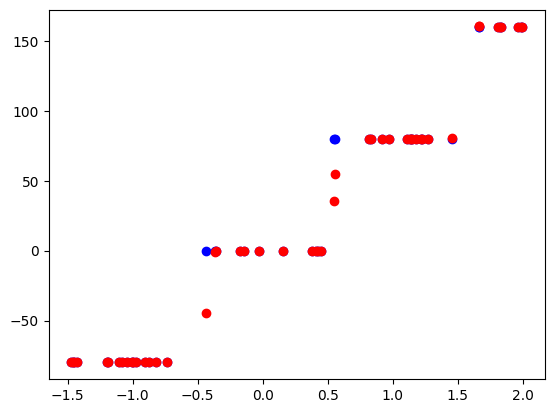

In [14]:
X_test = test_df["x"].values.reshape(-1, 1)
y_test = test_df["y"].values.reshape(-1, 1)

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = output_normalizer.reverse(y_pred_scaled)

plt.plot(X_test, y_test, "bo")
plt.plot(X_test, y_pred, "ro")

print(f"MSE: {mf.mse(y_pred, y_test)}")


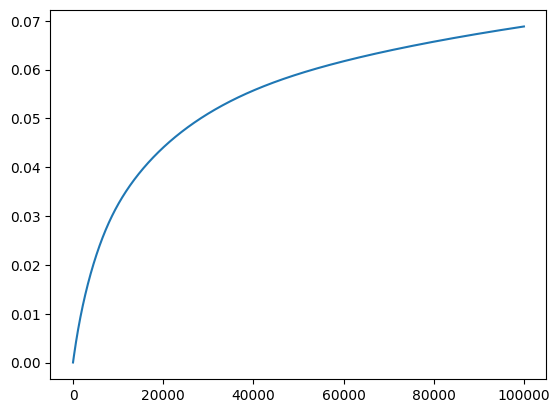

In [15]:
plt.plot(trainer.params_angle_diffs)

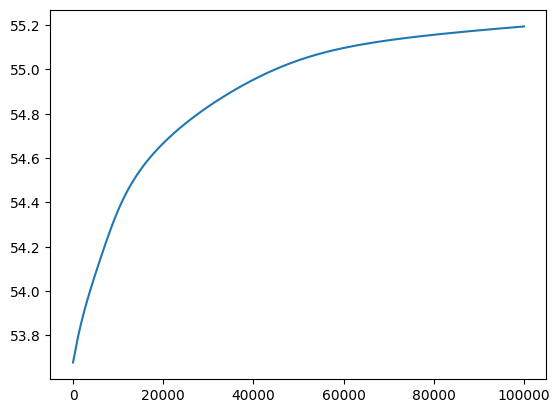

In [16]:
plt.plot(trainer.params_lengths)

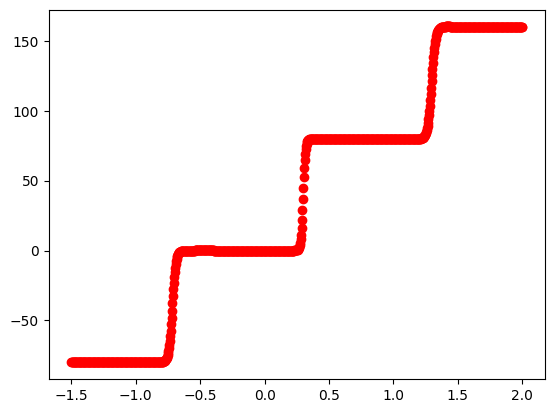

In [17]:
X_seq = np.linspace(-1.5, 2, 1000).reshape(-1, 1)
y_seq = model.forward(X_seq)
plt.plot(X_seq, output_normalizer.reverse(y_seq), "ro")

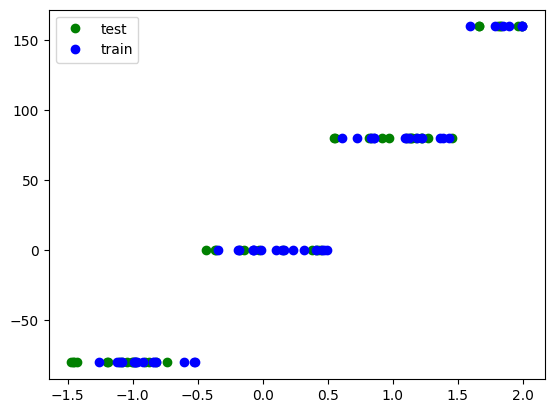

In [18]:
plt.plot(X_test, y_test, "go", label="test")
plt.plot(X_train, y_train, "bo", label="train")
plt.legend()